In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import ccxt
import pandas as pd
import time

def fetch_ohlcv(exchange, symbol, timeframe, since, limit=500):
    all_ohlcv = []
    while since < exchange.parse8601('2022-01-31T00:00:00Z'):
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit)
        if len(ohlcv) == 0:
            break
        since = ohlcv[-1][0] + 1
        all_ohlcv += ohlcv
        time.sleep(exchange.rateLimit / 1000)
    return all_ohlcv

exchange = ccxt.binance()
symbol = 'BTC/USDT'
timeframe = '1d'  # daily data
since = exchange.parse8601('2018-01-01T00:00:00Z')


In [3]:
ohlcv = fetch_ohlcv(exchange, symbol, timeframe, since)
data = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
data.head()

,timestamp,open,high,low,close,volume
0,2018-01-01,13715.65,13818.55,12750.00,13380.00,8609.915844
1,2018-01-02,13382.16,15473.49,12890.02,14675.11,20078.092111
2,2018-01-03,14690.00,15307.56,14150.00,14919.51,15905.667639
3,2018-01-04,14919.51,15280.00,13918.04,15059.54,21329.649574
4,2018-01-05,15059.56,17176.24,14600.00,16960.39,23251.491125


In [4]:
data.drop(index=data.index[1492:],inplace=True)

In [5]:
data.tail()

,timestamp,open,high,low,close,volume
1487,2022-01-27,36807.24,37234.47,35507.01,37160.10,53020.87934
1488,2022-01-28,37160.11,38000.00,36155.01,37716.56,42154.26956
1489,2022-01-29,37716.57,38720.74,37268.44,38166.84,26129.49682
1490,2022-01-30,38166.83,38359.26,37351.63,37881.76,21430.66527
1491,2022-01-31,37881.75,38744.00,36632.61,38466.90,36855.24580


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  1492 non-null   datetime64[ns]
 1   open       1492 non-null   float64       
 2   high       1492 non-null   float64       
 3   low        1492 non-null   float64       
 4   close      1492 non-null   float64       
 5   volume     1492 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 70.1 KB


In [7]:
data.set_index("timestamp",inplace=True)

# **Exploratory Data Analysis**

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

<Axes: xlabel='timestamp'>

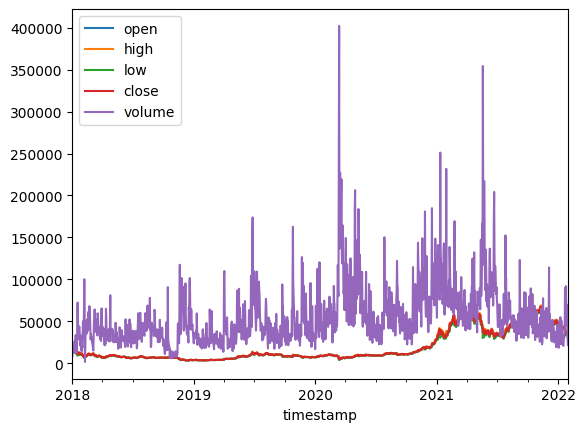

In [9]:
data.plot()

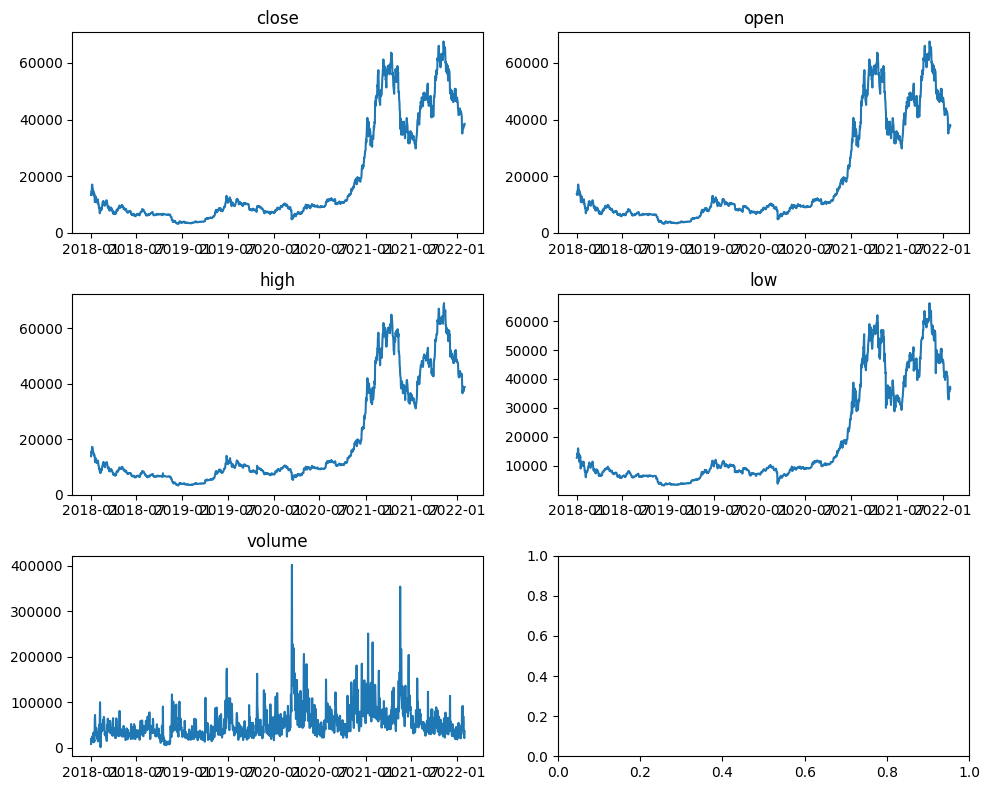

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(10, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# List of columns you want to plot
columns_to_plot = ["close", "open", "high", "low","volume"]

# Loop through axes and columns to plot each one
for ax, column in zip(axes, columns_to_plot):
    ax.plot(data[column])
    ax.set_title(column)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

# **Time-series models**

### **Arima model-**

#### **Checking for data is stationary or not**

In [11]:
data_close = data[["close"]].copy()

In [12]:
from statsmodels.tsa.stattools import adfuller

In [13]:
# function for checking Dickey–Fuller
def adf_test(series):
    result = adfuller(series)
    print("ADF Stastics : {}".format(result[0]))
    print("P- value : {}".format(result[1]))
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is not stationary")

In [14]:
adf_test(data_close["close"])

ADF Stastics : -0.9228929107209342
P- value : 0.7803400057685705
Data is not stationary


**To make data stationary we should apply diffrencing**

In [15]:
# assuming data is not seasonal
data_close["close 1 diffrencing"] = data_close["close"] - data_close["close"].shift(1)

In [16]:
adf_test(data_close["close 1 diffrencing"].dropna())

ADF Stastics : -8.27240294534156
P- value : 4.754323520053948e-13
Data is stationary


<Axes: xlabel='timestamp'>

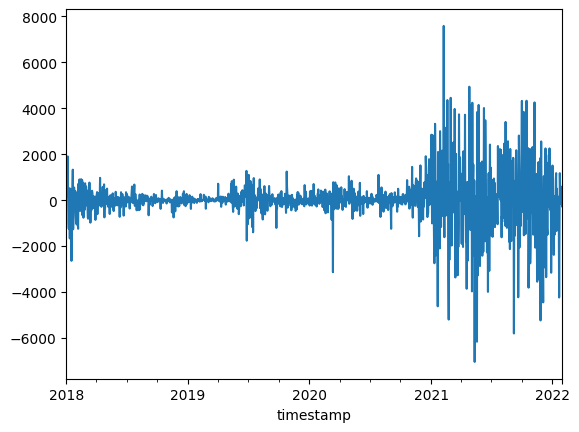

In [17]:
data_close["close 1 diffrencing"].plot()

### **Checking for data is seasonal or not**

In [18]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

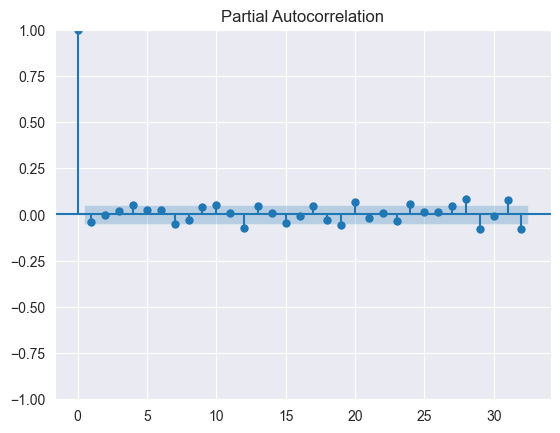

In [19]:
sns.set_style("darkgrid")
pacf = plot_pacf(data_close["close 1 diffrencing"].dropna()) #value of p is determined by pacf

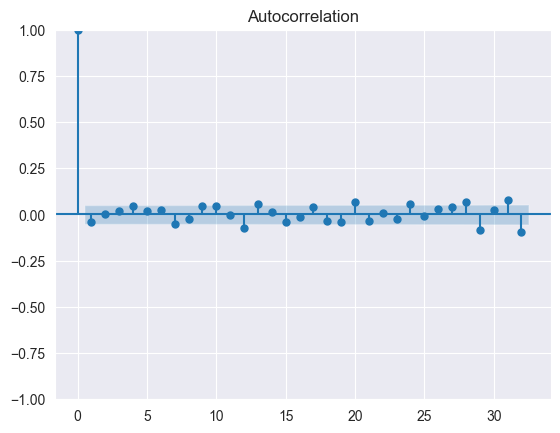

In [20]:
acf = plot_acf(data_close["close 1 diffrencing"].dropna()) #value of q is determined by acf

In [21]:
from pmdarima.arima.utils import ndiffs
d = ndiffs(data_close.close,test='adf')
print("Value of 'd' : ",d)

Value of 'd' :  1


In [22]:
from statsmodels.tsa.arima.model import ARIMA

In [23]:
model = ARIMA(data_close.close,order=(5,1,5))

c:\Users\lokes\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lokes\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lokes\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [24]:
model_arima = model.fit()

In [25]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 1492
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -12427.553
Date:                Tue, 30 Jul 2024   AIC                          24877.106
Time:                        11:32:03   BIC                          24935.485
Sample:                    01-01-2018   HQIC                         24898.861
                         - 01-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1885      0.237     -0.795      0.427      -0.653       0.276
ar.L2          0.4474      0.238      1.882      0.060      -0.019       0.913
ar.L3         -0.7044      0.089     -7.895      0.000      -0.879      -0.530
ar.L4         -0.1067      0.238     -0.449      0.654      -0.573       0.360
ar.L5          0.7640      0.222      3.445      0.001       0.329       1.199
ma.L1          0.1696      0.245      0.692      0.489      -0.311       0.650
ma.L2         -0.4317      0.240     -1.800      0.072      -0.902       0.038
ma.L3          0.7224      0.087      8.271      0.000       0.551       0.894
ma.L4          0.1400      0.246      0.570      0.569      -0.342       0.622
ma.L5         -0.7642      0.235     -3.249      0.001      -1.225      -0.303
sigma2      1.022e+06   1.67e+04     61.380      0.000     9.9e+05    1.06e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.75   Jarque-Bera (JB):              5572.78
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):              21.49   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(array([2.34744162e-06, 8.71906888e-06, 4.72841813e-05, 4.12143679e-04,
        2.34744162e-05, 5.70092966e-06, 3.35348803e-07, 0.00000000e+00,
        0.00000000e+00, 3.35348803e-07]),
 array([-6606.39268684, -4607.75341816, -2609.11414948,  -610.47488079,
         1388.16438789,  3386.80365658,  5385.44292526,  7384.08219395,
         9382.72146263, 11381.36073132, 13380.        ]),
 <BarContainer object of 10 artists>)

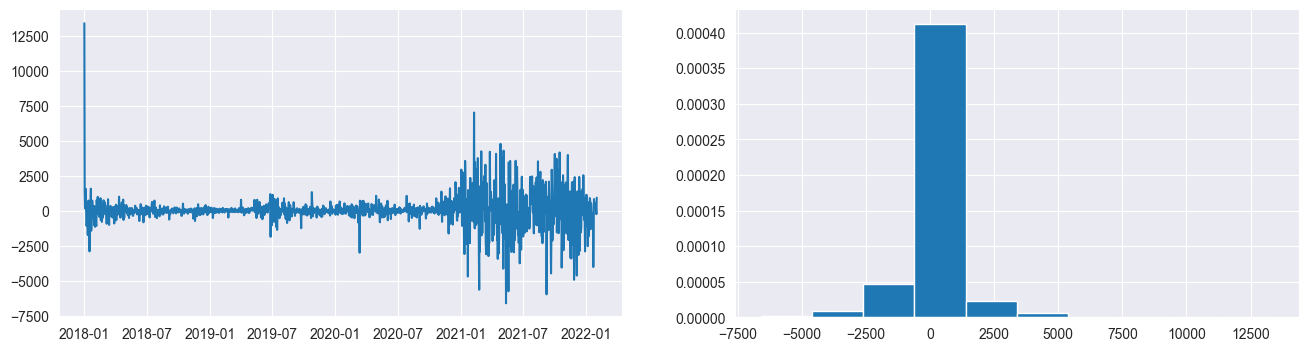

In [26]:
residuals = pd.DataFrame(model_arima.resid)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(residuals)
ax2.hist(residuals,density=True)

In [27]:
from datetime import datetime,timedelta
train_data_end = datetime(2021,1,1)
test_data_end = datetime(2022,1,1)

In [28]:
train_data = data_close[:train_data_end]
test_data = data_close[train_data_end + timedelta(days=1):test_data_end]

In [29]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [30]:
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]

In [31]:
pred=model_arima.predict(start=pred_start_date,end=pred_end_date)
residuals=test_data['close']-pred

<Axes: ylabel='Density'>

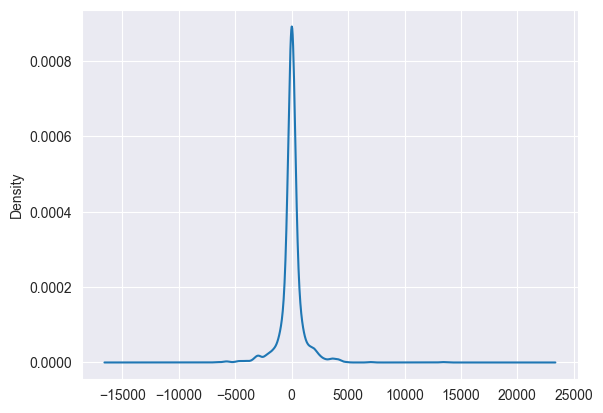

In [32]:
model_arima.resid.plot(kind='kde')

In [33]:
test_data['Predicted_ARIMA']=pred

In [34]:
test_data['Predicted_ARIMA']=pred

<Axes: xlabel='timestamp'>

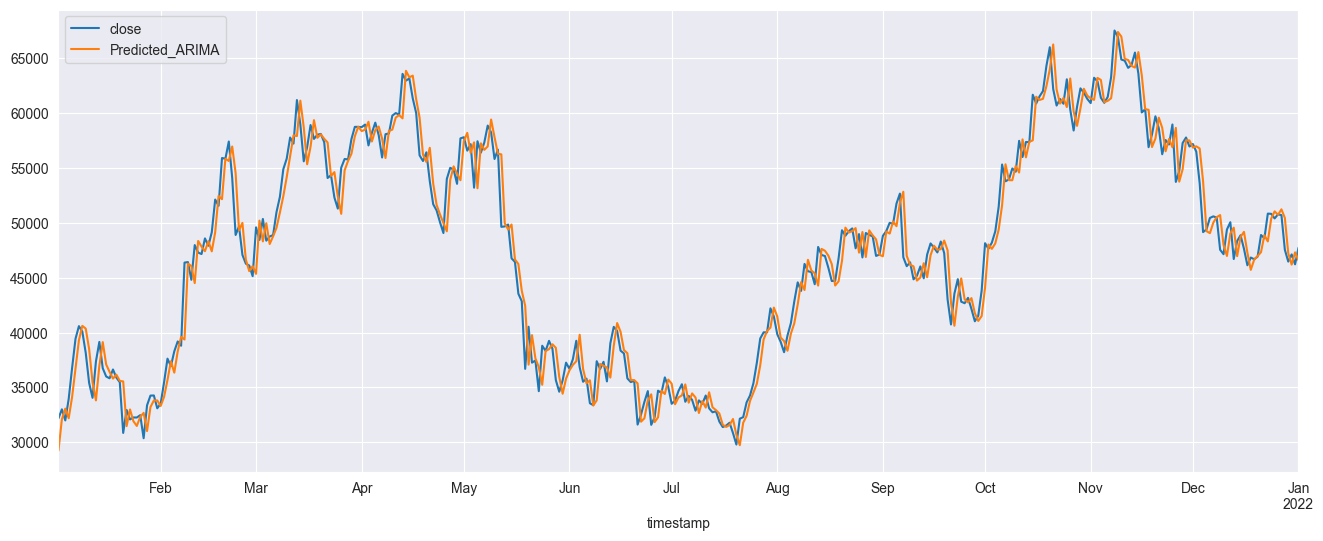

In [35]:
test_data[['close','Predicted_ARIMA']].plot(figsize=(16,6))

## **Forecasting**

In [36]:
forecasts = model_arima.forecast(len(test_data))

In [37]:
import plotly.graph_objects as go

def plot_forecasts(forecasts: list[float], title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_data.index, y=train_data['close'], name='Train'))
    fig.add_trace(go.Scatter(x=test_data.index, y=test_data['close'], name='Test'))
    fig.add_trace(go.Scatter(x=forecasts.index, y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=800, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Price')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts, 'ARIMA')

### **We can see ARIMA is not performing very well for forecasting**

### **LSTM model (LONG SHORT TERM MEMORY) -**

In [109]:
data_close_lstm = data.reset_index()['close']

In [110]:
data_close_lstm

0       13380.00
1       14675.11
2       14919.51
3       15059.54
4       16960.39
          ...   
1487    37160.10
1488    37716.56
1489    38166.84
1490    37881.76
1491    38466.90
Name: close, Length: 1492, dtype: float64

In [111]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [112]:
scaler = MinMaxScaler(feature_range=(0,1))
data_close_lstm=scaler.fit_transform(np.array(data_close_lstm).reshape(-1,1))

In [113]:
data_close_lstm

array([[0.15810341],
       [0.17824067],
       [0.18204077],
       ...,
       [0.54350624],
       [0.53907362],
       [0.54817178]])

### **Splitting data**

In [132]:
training_size=int(len(data_close_lstm)*0.65)
test_size=len(data_close_lstm)-training_size
train_data,test_data=data_close_lstm[0:training_size,:],data_close_lstm[training_size:len(data_close_lstm),:1]

In [133]:
train_data.shape

(969, 1)

In [134]:
test_data.shape

(523, 1)

In [135]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [136]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [137]:
X_train.shape,y_train.shape

((868, 100), (868,))

In [138]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [139]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [140]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [141]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [142]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - loss: 0.0020 - val_loss: 0.1073
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 4.9151e-04 - val_loss: 0.0094
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 2.1701e-04 - val_loss: 0.0093
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 1.8465e-04 - val_loss: 0.0107
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 1.4769e-04 - val_loss: 0.0087
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 1.6714e-04 - val_loss: 0.0081
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 1.3293e-04 - val_loss: 0.0112
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 1.4114e-04 - val_loss: 0.0072
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 1.2992e-04 - val_loss: 0.0100
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 1.3246e-04 - val_loss: 0.0091
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 1.2309e-04 - val_loss: 0.0124
E

In [102]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [103]:

train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [104]:

import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

8052.142265489023

In [105]:
math.sqrt(mean_squared_error(ytest,test_predict))


47865.9217147009

In [107]:
data_close_lstm

0       13380.00
1       14675.11
2       14919.51
3       15059.54
4       16960.39
          ...   
1487    37160.10
1488    37716.56
1489    38166.84
1490    37881.76
1491    38466.90
Name: close, Length: 1492, dtype: float64

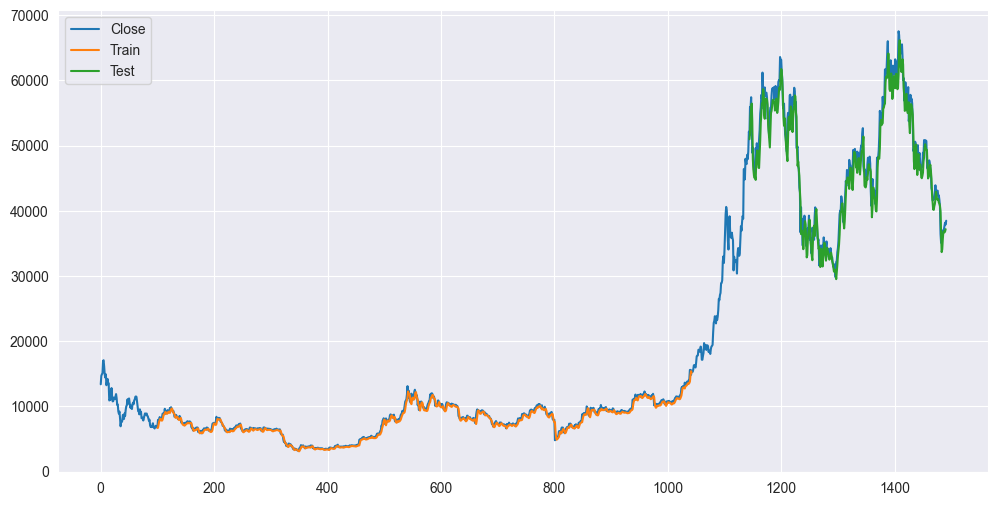

In [182]:
plt.figure(figsize=(12,6))

look_back=100
trainPredictPlot = numpy.empty_like(data_close_lstm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(data_close_lstm)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data_close_lstm)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data_close_lstm),label="Close")
plt.plot(trainPredictPlot,label="Train")
plt.plot(testPredictPlot,label="Test")
plt.legend()
plt.show()

In [149]:
len(test_data)

523

In [150]:
x_input=test_data[423:].reshape(1,-1)
x_input.shape

(1, 100)

In [151]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [152]:
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.4616139]
101
1 day input [0.93085421 0.88809578 0.8583143  0.89193755 0.91802545 0.91189119
 0.9031934  0.89714979 0.93304984 0.92801968 0.9046738  0.89755421
 0.90584928 0.93388325 1.         0.99101022 0.9588986  0.9572167
 0.94707849 0.95108647 0.96879798 0.93906329 0.88389857 0.8883455
 0.83465199 0.85269811 0.87843539 0.86155744 0.8246318  0.8447532
 0.83848739 0.86681818 0.785439   0.80090217 0.84061118 0.84840683
 0.83556843 0.83919921 0.82825713 0.78348795 0.71431837 0.71811007
 0.73436762 0.73665375 0.73482273 0.68933349 0.6830355  0.71801149
 0.72833442 0.67622844 0.70173652 0.70984827 0.69068296 0.66734158
 0.67827666 0.67589383 0.67951558 0.71023544 0.70554409 0.74053874
 0.74024627 0.73371053 0.7395542  0.73840282 0.68930473 0.67252645
 0.68272965 0.66867457 0.69208654 0.68530001 0.67223787 0.66268957
 0.62567001 0.61993535 0.59636618 0.59812722 0.60100186 0.6003468
 0.61444635 0.63269071 0.61181582 0.61958783 0.61996613 0.61976975
 0.60624177 0.60858185 0.59782045 0.58

In [153]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [154]:
import matplotlib.pyplot as plt

In [155]:
len(data_close_lstm)

1492

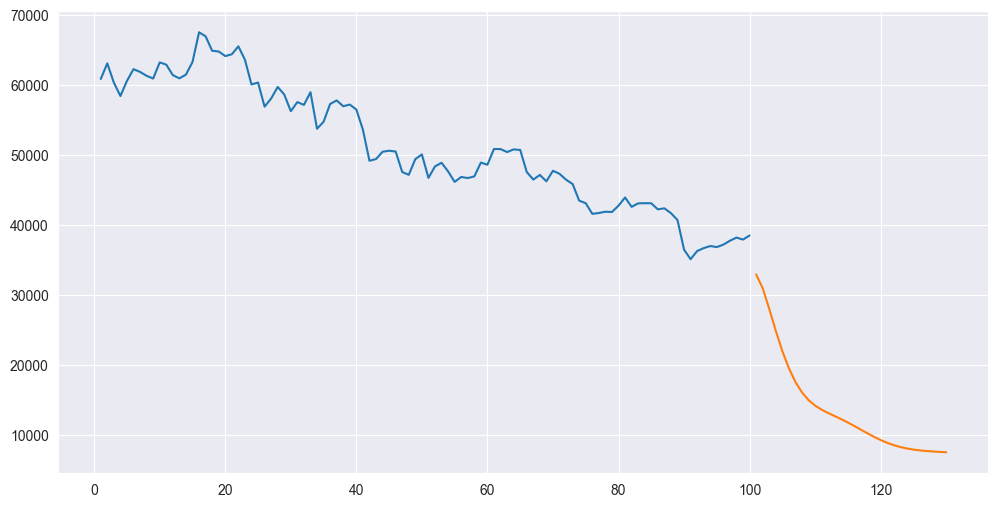

In [181]:
plt.figure(figsize=(12,6))
plt.plot(day_new,scaler.inverse_transform(data_close_lstm[1392:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

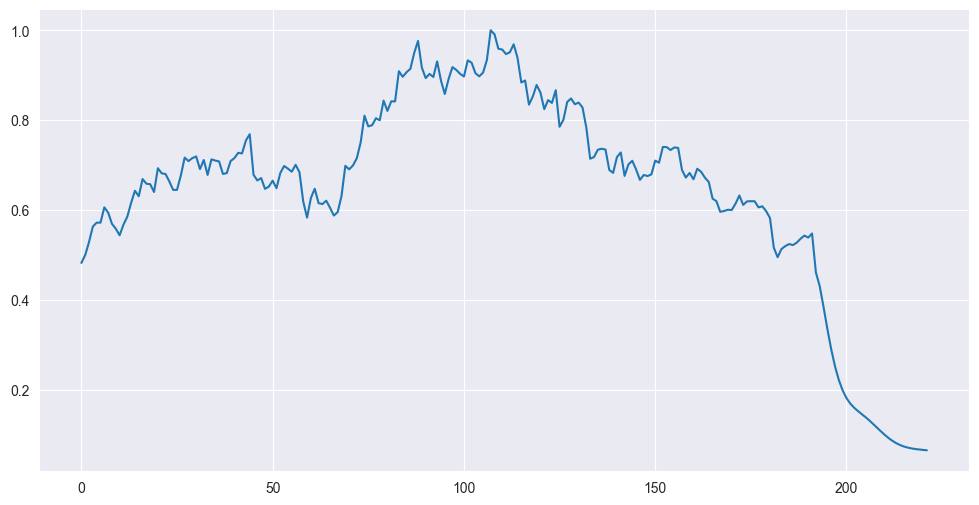

In [180]:
data_close_lstm_forecast=data_close_lstm.tolist()
data_close_lstm_forecast.extend(lst_output)
plt.figure(figsize=(12,6))
plt.plot(data_close_lstm_forecast[1300:])

In [158]:
data_close_lstm_forecast=scaler.inverse_transform(data_close_lstm_forecast).tolist()


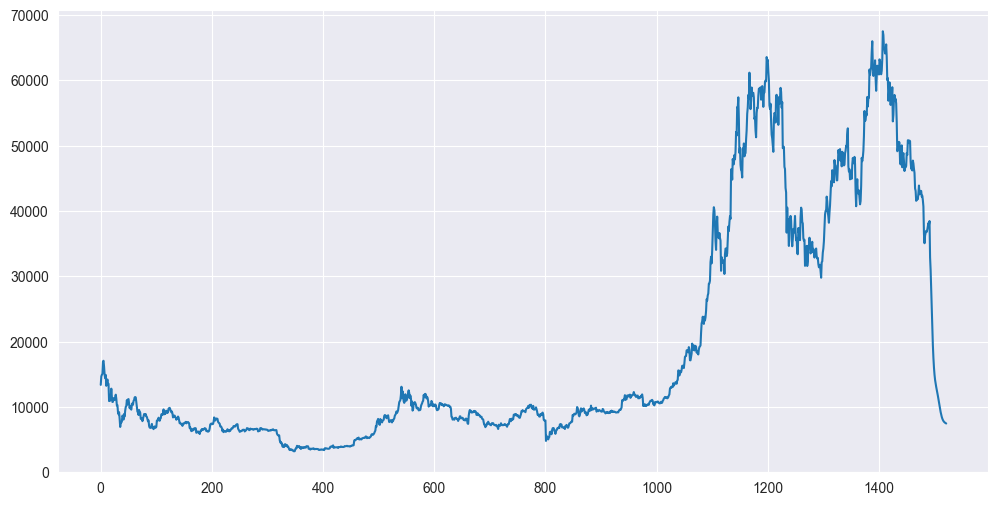

In [179]:
plt.figure(figsize=(12,6))
plt.plot(data_close_lstm_forecast)

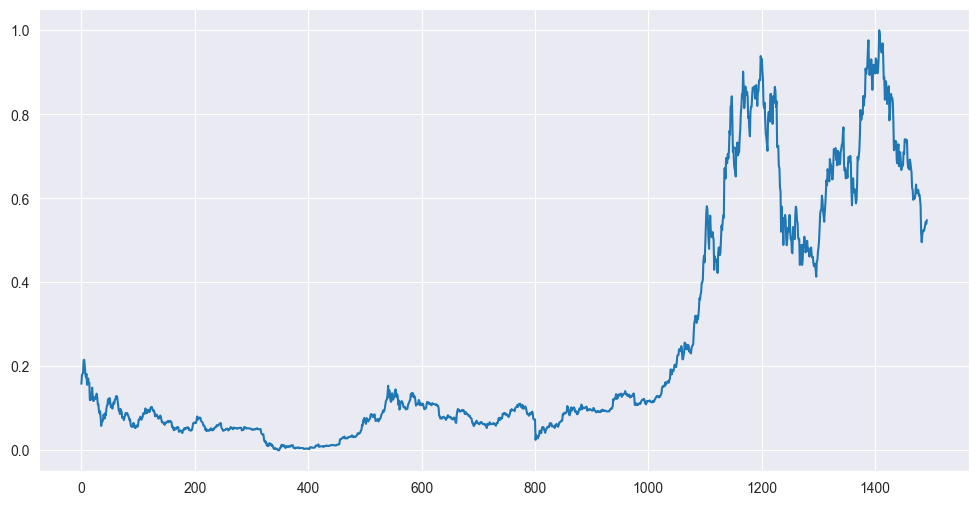

In [178]:
plt.figure(figsize=(12,6))
plt.plot(data_close_lstm)
